In [1]:
import pandas as pd

# File paths
human_eval_path = "cold_case_analyzer/data/gpt_evaluation_ranking_human.csv"
geval_eval_path = "cold_case_analyzer/data/evaluations/geval_evaluation_detailed_20250213_092412.csv"
bertopic_eval_path = "cold_case_analyzer/data/evaluations/bertopic_evaluation_detailed_20250213_092231.csv"

# Load the data
dataframes = {
    "human_eval": pd.read_csv(human_eval_path),
    "geval_eval": pd.read_csv(geval_eval_path),
    "bertopic_eval": pd.read_csv(bertopic_eval_path),
}

# Rename 'Column metric' in human_eval to match others
dataframes["human_eval"].rename(columns={"Column metric": "Column"}, inplace=True)

# Define a mapping to standardize column names in human_eval
column_mapping = {
    "Abstract Accuracy": "Abstract",
    "Abstract Conciseness": "Abstract",
    "Relevant Facts Accuracy": "Relevant facts / Summary of the case",
    "Relevant Facts Focus on PIL": "Relevant facts / Summary of the case",
    "Relevant Facts Conciseness": "Relevant facts / Summary of the case",
    "PIL Provisions Adherence to Format": "PIL provisions",
    "PIL Provisions Accuracy": "PIL provisions",
    "Choice of Law Issue Classification Accuracy": "Choice of law issue",
    "Choice of Law Issue Correct Identification of CoLI": "Choice of law issue",
    "Choice of Law Issue Precision of Phrasing": "Choice of law issue",
    "Court's Position Does it Answer the CoLI": "Court's position",
    "Court's Position Conciseness": "Court's position",
}

dataframes["human_eval"]["Column"] = dataframes["human_eval"]["Column"].replace(column_mapping)

# Filter only common IDs
common_ids = set(dataframes["geval_eval"]["ID"]) & set(dataframes["bertopic_eval"]["ID"])
human_filtered = dataframes["human_eval"][dataframes["human_eval"]["ID"].isin(common_ids)]

# Merge datasets
merged_df = human_filtered.merge(dataframes["geval_eval"], on=["ID", "Column"], suffixes=('_human', '_geval'))
merged_df = merged_df.merge(dataframes["bertopic_eval"], on=["ID", "Column"])

# Compute BERTScore average
merged_df["BERT_Avg"] = merged_df[["BERT_Precision", "BERT_Recall", "BERT_F1"]].mean(axis=1)

# Compute correlation overall
correlation_matrix = merged_df[["Human_score", "G_Eval_Score", "BERT_Avg"]].corr()
correlation_matrix.to_csv("cold_case_analyzer/data/evaluations/evaluation_correlation_matrix.csv")

# Compute correlation per category
category_correlation = merged_df.groupby("Column")[["Human_score", "G_Eval_Score", "BERT_Avg"]].corr()
category_correlation.to_csv("cold_case_analyzer/data/evaluations/evaluation_correlation_per_category.csv")

# Save outputs
merged_df.to_csv("cold_case_analyzer/data/evaluations/merged_evaluation_data.csv", index=False)

# Print results
print("Merged dataset saved as merged_evaluation_data.csv")
print("Overall correlation matrix saved as evaluation_correlation_matrix.csv")
print(correlation_matrix)
print("Category-wise correlation matrix saved as evaluation_correlation_per_category.csv")
print(category_correlation)


Merged dataset saved as merged_evaluation_data.csv
Overall correlation matrix saved as evaluation_correlation_matrix.csv
              Human_score  G_Eval_Score  BERT_Avg
Human_score      1.000000     -0.018741  0.204084
G_Eval_Score    -0.018741      1.000000  0.319662
BERT_Avg         0.204084      0.319662  1.000000
Category-wise correlation matrix saved as evaluation_correlation_per_category.csv
                                                   Human_score  G_Eval_Score  \
Column                                                                         
Abstract                             Human_score      1.000000     -0.456690   
                                     G_Eval_Score    -0.456690      1.000000   
                                     BERT_Avg         0.104745      0.415969   
Choice of law issue                  Human_score      1.000000      0.434890   
                                     G_Eval_Score     0.434890      1.000000   
                                     

/tmp/ipykernel_22612/811687276.py:10: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  "human_eval": pd.read_csv(human_eval_path),


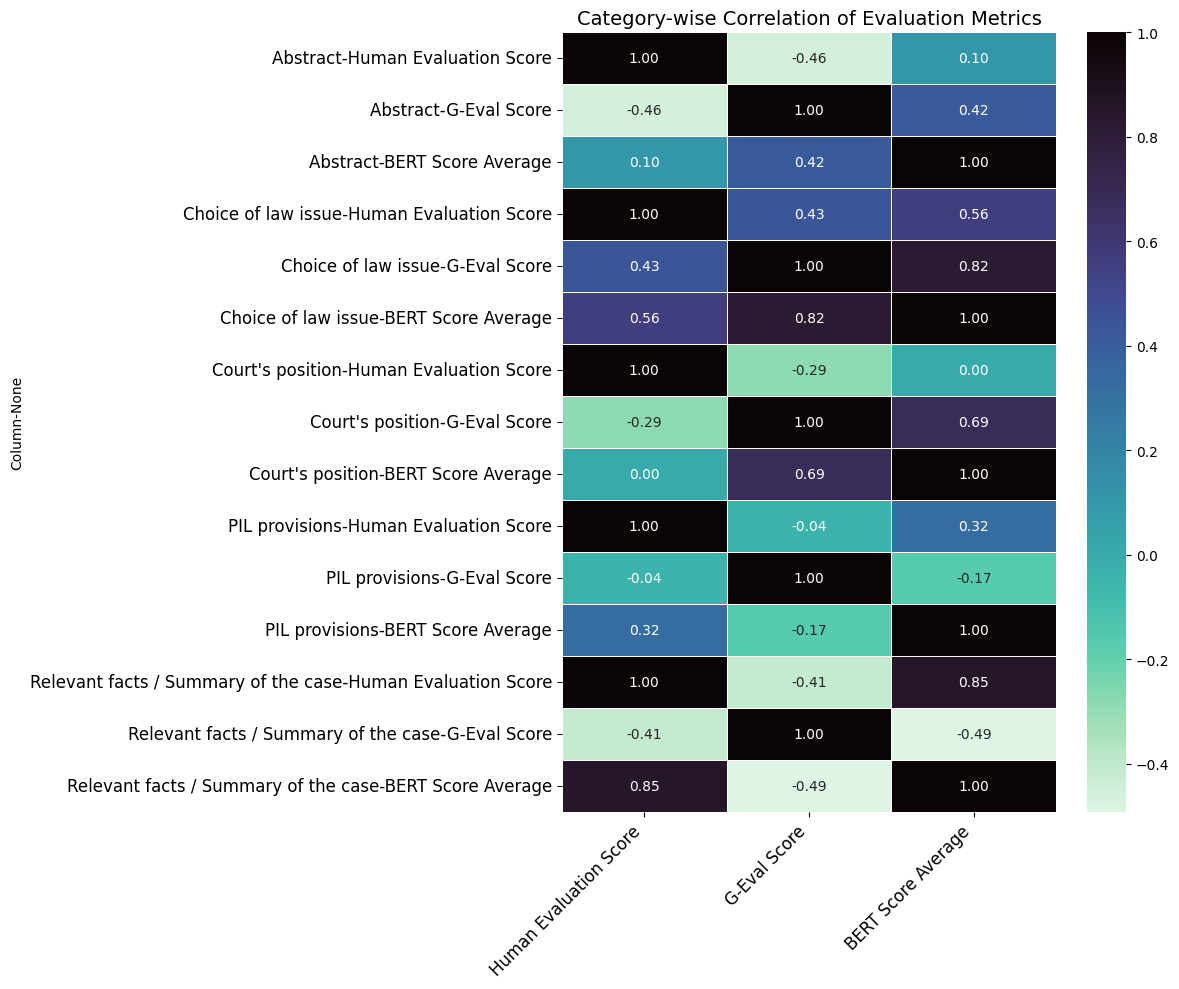

'category_correlation_heatmap_updated.png'

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Update the labels for better expressiveness
renamed_columns = {
    "Human_score": "Human Evaluation Score",
    "G_Eval_Score": "G-Eval Score",
    "BERT_Avg": "BERT Score Average",
}

category_correlation_renamed = category_correlation.rename(columns=renamed_columns, index=renamed_columns)

# Use a different color palette suitable for scientific publications
plt.figure(figsize=(12, 10))
sns.heatmap(category_correlation_renamed, annot=True, fmt=".2f", cmap="mako_r", linewidths=0.5, cbar=True)

# Update title and axis labels
plt.title("Category-wise Correlation of Evaluation Metrics", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the updated figure
updated_plot_path = "category_correlation_heatmap_updated.png"
plt.savefig(updated_plot_path, dpi=300)

# Display the updated figure
plt.show()

# Provide the file path for download
updated_plot_path